In [394]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import DataStructs
from IPython.display import display
from massspecgym.data.transforms import MolFingerprinter
from massspecgym.data.datasets import MSnDataset
from massspecgym.utils import (
    morgan_fp, init_plotting, smiles_to_scaffold,
    train_val_test_split, create_split_file
    )
%reload_ext autoreload
%autoreload 2
%matplotlib inline     
tqdm.pandas()
sns.set_theme(color_codes=True)

In [323]:
datasets_paths = ["../../data/MSn/20231031_nihnp_library_pos_all_lib_MSn.mgf",
                  "../../data/MSn/20231130_mcescaf_library_pos_all_lib_MSn.mgf",
                  "../../data/MSn/20231130_otavapep_library_pos_all_lib_MSn.mgf",
                  "../../data/MSn/20240411_mcebio_library_pos_all_lib_MSn.mgf"]

In [324]:
# merge datasets into a single mgf file
if os.path.exists("../../data/MSn/all_MSn_spectra.mgf"):
    print("merged mgf file already exists in data/MSn/all_MSn_spectra.mgf")
else:
    with open("../../data/MSn/all_MSn_spectra.mgf", "w") as outfile:
        for dataset_path in datasets_paths:
            print(dataset_path)
            with open(dataset_path, "r") as infile:
                for line in infile:
                    outfile.write(line)
                infile.close()
    print("merged mgf file was successfully created in data/MSn/all_MSn_spectra.mgf")

../../data/MSn/20231031_nihnp_library_pos_all_lib_MSn.mgf
../../data/MSn/20231130_mcescaf_library_pos_all_lib_MSn.mgf
../../data/MSn/20231130_otavapep_library_pos_all_lib_MSn.mgf
../../data/MSn/20240411_mcebio_library_pos_all_lib_MSn.mgf
merged mgf file was successfully created in data/MSn/all_MSn_spectra.mgf


In [325]:
fingerprinter = MolFingerprinter()
msn_dataset = MSnDataset(pth="../../data/MSn/all_MSn_spectra.mgf", mol_transform=MolFingerprinter.from_smiles)
print(len(msn_dataset))
msn_dataset.metadata.to_csv("../../data/MSn/all_MSn_spectra.csv")

16476


In [326]:
# do some basic data analysis on the merged datasets
metadata_df = pd.read_csv("../../data/MSn/all_MSn_spectra.csv")
trees_total = 0  # number of occurances of "ms_level" == 2
for ms_level, precursor_mz in zip(metadata_df["ms_level"], metadata_df["precursor_mz"]):
    if int(ms_level) == 2:
        trees_total += 1
print("Total number of MSn trees:", trees_total)

branching = []
branching_factors = []
for tree in msn_dataset.trees:
    branching.append(tree.get_depth())
    branching_factors.append(tree.get_branching_factor())
print(f"Depths - min: {min(branching)}; max: {max(branching)}; average {round(np.average(branching), 3)}")
print(f"Branching factors - min: {min(branching_factors)}; max: {max(branching_factors)}; average {round(np.average(branching_factors), 3)}")
print()

C:\Users\Lukas\AppData\Local\Temp\ipykernel_17784\766026674.py:2: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv("../../data/MSn/all_MSn_spectra.csv")


Total number of MSn trees: 16476
Depths - min: 0; max: 3; average 2.131
Branching factors - min: 0; max: 10; average 4.455



In [327]:
# generate scaffolds
all_smiles = [smi for smi in msn_dataset.smiles]
scaffolds = [smiles_to_scaffold(smi) for smi in all_smiles]
print(len(all_smiles))

# perform scaffold split
train, validation, test = train_val_test_split(all_smiles, scaffolds, n_splits=5)
print(len(train), len(validation), len(test))
print(len(train)+len(validation)+len(test), len(all_smiles))

# and save the split into a file
split_tsv_path = "../../data/MSn/MSn_splits.tsv"
create_split_file(msn_dataset, train, validation, test, split_tsv_path)

16476
9885 3295 3296
16476 16476
split tsv file was created successfully at ../../data/MSn/MSn_splits.tsv


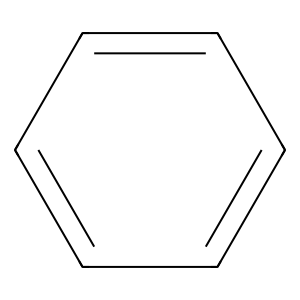

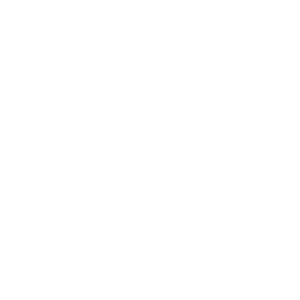

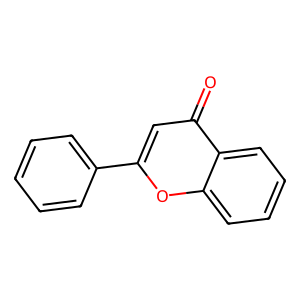

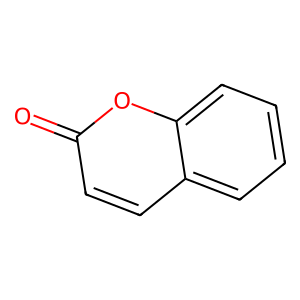

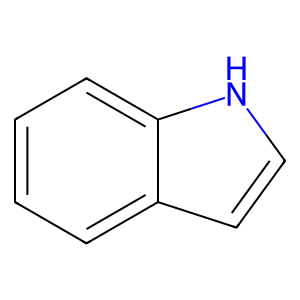

In [395]:
counts = {}
for s in scaffolds:
    counts[s] = counts.get(s, 0) + 1

most_common_strings = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]

common_smi = [tup[0] for tup in most_common_strings]
for smi in common_smi:
    mol = Chem.MolFromSmiles(smi)
    Chem.rdDepictor.Compute2DCoords(mol)
    img = Chem.Draw.MolToImage(mol)
    display(img)

In [328]:
# get Tanimoto similarities
tanimoto_df = pd.DataFrame(columns=["identifier", "fold"])
split_smiles = [
    ("train", [all_smiles[i] for i in train]), 
    ("val", [all_smiles[i] for i in validation]),
    ("test", [all_smiles[i] for i in test])
    ]

rows = []
# create the dataframe row by row
for fold, fold_smiles in split_smiles:
    for smi in fold_smiles:
        rows.append({"smiles": smi, "fold": fold})

# concatenate the rows into the dataframe
tanimoto_df = pd.concat([tanimoto_df, pd.DataFrame(rows)], ignore_index=True)

fps = {}
for fold in ['train', 'val', 'test']:
    print(fold)
    df_fold = tanimoto_df[tanimoto_df['fold'] == fold]
    df_fold = df_fold.drop_duplicates(subset='smiles')
    fps[fold] = df_fold['smiles'].progress_apply(lambda s: morgan_fp(Chem.MolFromSmiles(s), to_np=False))

def max_tanimoto(target_fp, comparison_fps):
    return np.max([DataStructs.FingerprintSimilarity(target_fp, comparison_fp) for comparison_fp in comparison_fps])

train


100%|██████████| 8416/8416 [00:02<00:00, 3231.09it/s]


val


100%|██████████| 2763/2763 [00:00<00:00, 3119.91it/s]


test


100%|██████████| 2805/2805 [00:02<00:00, 1356.30it/s]


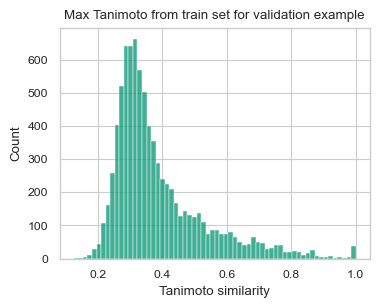

In [359]:
# Tanimoto similarity between train and validation molecules
max_train_tanimotos = []
for train_fp in fps['train']:
    max_train_tanimotos.append(max_tanimoto(train_fp, fps["val"]))

init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.title('Max Tanimoto from train set for validation example')
plt.xlabel("Tanimoto similarity")
plt.show()

In [360]:
print(max_train_tanimotos.count(1))
print(np.average(max_train_tanimotos))

39
0.3879148090717561


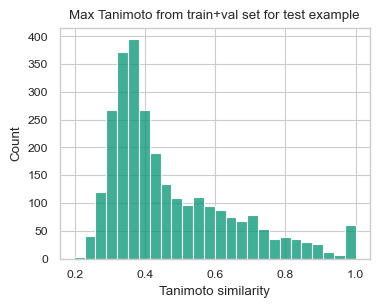

In [348]:
# Tanimoto similarity between train+validation and test molecules
train_val_fps = pd.concat([pd.Series(fps['train']), pd.Series(fps['val'])])

max_train_tanimotos = []
for test_fp in fps['test']:
    max_train_tanimotos.append(max_tanimoto(test_fp, train_val_fps))

init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.title('Max Tanimoto from train+val set for test example')
plt.xlabel("Tanimoto similarity")
plt.show()

In [358]:
print(max_train_tanimotos.count(1))
print(np.average(max_train_tanimotos))

57
0.4711374503677016


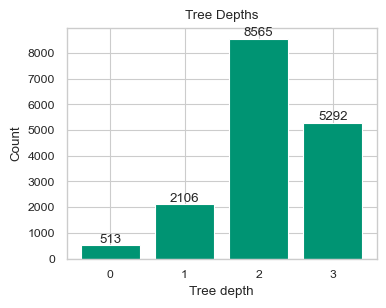

In [379]:
branching = msn_dataset.tree_depths
bins = [0, 1, 2, 3, 4]  # Extend the bins to include the upper edge

counts, _ = np.histogram(branching, bins=bins)

plt.bar(bins[:-1], counts, width=0.8, align='center')
plt.title("Tree Depths")
plt.xlabel("Tree depth")
plt.ylabel("Count")
plt.xticks(bins[:-1])

# Add the number of occurrences above the bars
for i, count in enumerate(counts):
    plt.text(bins[i], count, str(count), ha='center', va='bottom')

plt.show()


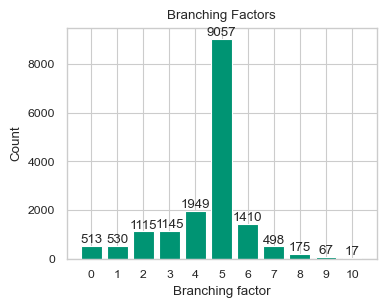

In [378]:
branching = msn_dataset.branching_factors
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

counts, _ = np.histogram(branching, bins=bins)

plt.bar(bins[:-1], counts, width=0.8, align='center')
plt.title("Branching Factors")
plt.xlabel("Branching factor")
plt.ylabel("Count")
plt.xticks(bins[:-1])

# Add the number of occurrences above the bars
for i, count in enumerate(counts):
    plt.text(bins[i], count, str(count), ha='center', va='bottom')

plt.show()